# Self-Improving RAG Agent

## Overview

Traditional RAG systems have a critical limitation: they retrieve documents once and then generate an answer based on those documents, regardless of their relevance. An agentic approach allows the system to adapt its retrieval strategy based on objective performance metrics.

This notebook implements an agentic RAG system that uses established information retrieval metrics (Recall and MRR) to evaluate and improve retrieval quality, rather than relying on subjective LLM-based assessments.

## Setup

First, let's install the necessary libraries:

In [1]:
%pip install openai chromadb sentence_transformers pandas matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [21]:
import openai
import chromadb
from chromadb.utils import embedding_functions
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import getpass
import os
from typing import List, Dict, Any, Literal, Optional, Union, Tuple
import time
from tqdm import tqdm
from sentence_transformers import CrossEncoder

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Define paths
DATA_DIR = "../data/papers"
EVAL_DIR = "../data/evalset"

# Initialize OpenAI
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')

### Loading Evaluation Dataset

Let's load the eval set we created previously:

In [3]:
eval_df = pd.read_json('../data/evalset/ai_papers_eval_dataset.json')
print(f"Loaded {len(eval_df)} evaluation examples")
print(eval_df.head())

Loaded 26 evaluation examples
                  id                                                                                             document                                                                                                query                                                                                               answer
0  gpt_1.pdf_chunk_0  Improving Language Understanding\nby Generative Pre-Training\nAlec Radford\nOpenAI\nalec@openai....                             details on the generative pre-training methodology outlined in the paper  The document discusses a generative pre-training methodology that involves training a language m...
1  gpt_1.pdf_chunk_1  speciﬁc task. In contrast to previous approaches, we make use of task-aware input\ntransformatio...                                  details on the task-aware input transformations used in fine-tuning  The document mentions that task-aware input transformations are utilized during fine-tuning to a..

### Setting up Vector DB

Let's set up a ChromaDB collection:

In [4]:
# Initialize Chroma client
chroma_client = chromadb.PersistentClient()

# Initialize embedding function
embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="all-mpnet-base-v2" 
)

# Create or get collection
collection_name = "agentic_rag_collection"
try:
    chroma_client.delete_collection(name=collection_name)
    print(f"Deleted existing collection {collection_name}")
except:
    print(f"No existing collection {collection_name} to delete")

# Create collection
collection = chroma_client.create_collection(
    name=collection_name,
    embedding_function=embedding_function
)

# Add documents to Chroma
for _, row in eval_df.iterrows():
    collection.upsert(
        documents=[row['document']],
        ids=[row['id']],
        metadatas=[{'id': row['id'], 'query': row['query'], 'answer': row['answer']}]
    )

print(f"Created collection with {collection.count()} documents")

No existing collection agentic_rag_collection to delete
Created collection with 26 documents


### Defining Metrics

Let's define the metrics we'll use to evaluate our retrieval system. The two main metrics we'll focus on are:

1. **Recall@k**: The proportion of relevant documents that are retrieved in the top k results
2. **Mean Reciprocal Rank (MRR@k)**: Measures where in the ranking the first relevant document appears

In [5]:
def calculate_mrr(predictions: list[str], ground_truth: list[str]):
    mrr = 0
    for label in ground_truth:
        if label in predictions:
            # Find the relevant item that has the smallest index
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr

def calculate_recall(predictions: list[str], ground_truth: list[str]):
    return len([label for label in ground_truth if label in predictions]) / len(ground_truth)

# Define our metrics
metrics = [("recall", calculate_recall), ("mrr", calculate_mrr)]
k_values = [1, 3, 5, 10, 15, 20, 25, 30]

### Agent Components

Our Agent will have three main components: a retrieval component, query reformulation component and a retrieval evaluation component. 

In [12]:
def rerank_results(query, results, reranker_model, top_k=30):
    # Format results
    results = {"ids": results['ids'][0], "documents": results['documents'][0]}

    # Initialize cross-encoder
    cross_encoder = CrossEncoder(reranker_model)
    
    # Create pairs for reranking
    pairs = [(query, doc) for doc in results["documents"]]
    scores = cross_encoder.predict(pairs)
    
    # Sort by scores
    reranked_indices = np.argsort(-scores)[:top_k]
    
    # Return reranked results
    return {
        "ids": [results["ids"][i] for i in reranked_indices],
        "documents": [results["documents"][i] for i in reranked_indices]
    }

In [17]:
def retrieve(question, collection, max_k=10, reranker=None):
    """Basic retrieval function"""
    results = collection.query(
        query_texts=[question],
        n_results=max_k
    )

    if reranker:
        return rerank_results(question, results, reranker, max_k)
    
    return {"ids": results['ids'][0], "documents": results['documents'][0]}

def reformulate_query(original_query, retrieved_docs=None, metrics_feedback=None):
    """
    Reformulate a query to improve retrieval results based on objective metrics
    
    Args:
        original_query: The original user query
        retrieved_docs: Previously retrieved documents (optional)
        metrics_feedback: Feedback based on retrieval metrics (optional)
    
    Returns:
        A reformulated query
    """
    system_prompt = """You are an AI assistant that helps reformulate search queries to improve document retrieval.
                    Your goal is to create a more specific and targeted query that will help retrieve relevant documents."""
    
    user_message = f"Original query: {original_query}\n\n"
    
    if retrieved_docs and metrics_feedback:
        user_message += f"The following documents were retrieved but did not achieve good retrieval metrics:\n"
        for i, doc in enumerate(retrieved_docs[:3]):  # Include only first 3 docs for context
            user_message += f"Document {i+1}:\n{doc}\n\n"
        user_message += f"Metrics feedback: {metrics_feedback}\n\n"
    
    user_message += "Please reformulate the query to be more specific and targeted to improve retrieval performance. Return ONLY the reformulated query without any explanations or additional text."
    
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_message}
        ],
    )
    
    reformulated_query = response.choices[0].message.content.strip()
    return reformulated_query

def evaluate_retrieval(predictions, ground_truth):
    scores = {}
    for metric, score_fn in metrics:
        for subset_k in k_values:
            scores[f"{metric}@{subset_k}"] = score_fn(predictions[:subset_k], ground_truth)

    return scores

In [19]:
def agentic_rag(
    query,
    collection,
    ground_truth_ids,
    max_iterations=3,
    initial_k=10,
    target_recall=0.8,
    target_mrr=0.5,
    model="gpt-3.5-turbo",
    verbose=True,
    reranker_model=None
):
    """
    Agentic RAG pipeline that can reformulate queries based on objective metrics
    
    Args:
        query: The user query
        collection: ChromaDB collection
        ground_truth_ids: List of relevant document IDs for evaluation
        max_iterations: Maximum number of retrieval iterations
        initial_k: Initial number of documents to retrieve
        target_recall: Target recall value to achieve
        target_mrr: Target MRR value to achieve
        model: LLM model to use
        verbose: Whether to print detailed logs
    
    Returns:
        Dict containing the final answer and process details
    """
    current_query = query
    iteration = 0
    history = []
    best_metrics = {"recall@10": 0, "mrr@10": 0}
    best_retrieval = None
    
    while iteration < max_iterations:
        iteration += 1
        
        if verbose:
            print(f"\n--- Iteration {iteration} ---")
            print(f"Query: {current_query}")
        
        # Retrieve documents
        retrieval_results = retrieve(current_query, collection, max_k=initial_k, reranker=reranker_model)
        documents = retrieval_results["documents"]
        doc_ids = retrieval_results["ids"]
        
        # Evaluate retrieval performance
        metrics = evaluate_retrieval(doc_ids, ground_truth_ids)
        
        if verbose:
            print(f"Retrieved {len(documents)} documents")
            print(f"Recall@10: {metrics.get('recall@10', 0):.4f}")
            print(f"MRR@10: {metrics.get('mrr@10', 0):.4f}")
        
        # Record this iteration
        history.append({
            "iteration": iteration,
            "query": current_query,
            "retrieved_docs": documents,
            "doc_ids": doc_ids,
            "metrics": metrics
        })
        
        # Check if this is the best retrieval so far
        if metrics.get("recall@10", 0) > best_metrics["recall@10"] or \
           (metrics.get("recall@10", 0) == best_metrics["recall@10"] and 
            metrics.get("mrr@10", 0) > best_metrics["mrr@10"]):
            best_metrics = metrics
            best_retrieval = {
                "documents": documents,
                "doc_ids": doc_ids,
                "query": current_query
            }
        
        # Check if we've met our targets
        if metrics.get("recall@10", 0) >= target_recall and metrics.get("mrr@10", 0) >= target_mrr:
            if verbose:
                print("Target metrics achieved, generating answer...")
            
            # Generate answer with the current retrieval
            context = "\n\n".join(documents)
            
            response = openai.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided context."},
                    {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer the question based on the context provided. If the context doesn't contain the answer, say 'I don't have enough information to answer this question.'"}
                ]
            )
            
            answer = response.choices[0].message.content
            
            return {
                "query": query,
                "final_query": current_query,
                "answer": answer,
                "iterations": iteration,
                "history": history,
                "metrics": metrics,
                "success": True
            }
        
        # If we've reached the maximum iterations, use the best retrieval
        if iteration == max_iterations:
            if verbose:
                print("Maximum iterations reached, using best retrieval...")
            
            if best_retrieval:
                context = "\n\n".join(best_retrieval["documents"])
                
                response = openai.chat.completions.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided context."},
                        {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer the question based on the context provided. If the context doesn't contain the answer, say 'I don't have enough information to answer this question.'"}
                    ]
                )
                
                answer = response.choices[0].message.content
                
                return {
                    "query": query,
                    "final_query": best_retrieval["query"],
                    "answer": answer,
                    "iterations": iteration,
                    "history": history,
                    "metrics": best_metrics,
                    "success": True
                }
            else:
                if verbose:
                    print("No satisfactory retrieval found...")
                
                return {
                    "query": query,
                    "final_query": current_query,
                    "answer": "I don't have enough information to answer this question.",
                    "iterations": iteration,
                    "history": history,
                    "metrics": best_metrics,
                    "success": False
                }
        
        # Otherwise, reformulate the query and try again
        metrics_feedback = f"Current retrieval has Recall@10 of {metrics.get('recall@10', 0):.2f} and MRR@10 of {metrics.get('mrr@10', 0):.2f}, which are below our targets of {target_recall} and {target_mrr} respectively."
        
        current_query = reformulate_query(
            query,
            retrieved_docs=documents[:3],
            metrics_feedback=metrics_feedback
        )
        
        if verbose:
            print(f"Reformulated query: {current_query}")

### Testing the Agent

In [8]:
# Test on a single example
test_idx = 0
test_query = eval_df.iloc[test_idx]['query']
ground_truth_id = [eval_df.iloc[test_idx]['id']]

print(f"Testing query: {test_query}")
print(f"Ground truth ID: {ground_truth_id}")

result = agentic_rag(
    test_query,
    collection,
    ground_truth_id,
    max_iterations=3,
    initial_k=10,
    target_recall=0.8,
    target_mrr=0.5,
    verbose=True
)

Testing query: details on the generative pre-training methodology outlined in the paper
Ground truth ID: ['gpt_1.pdf_chunk_0']

--- Iteration 1 ---
Query: details on the generative pre-training methodology outlined in the paper
Retrieved 10 documents
Recall@10: 1.0000
MRR@10: 0.1667
Reformulated query: Generative pre-training methodology efficacy comparison with transformer and LSTM for NLP tasks

--- Iteration 2 ---
Query: Generative pre-training methodology efficacy comparison with transformer and LSTM for NLP tasks
Retrieved 10 documents
Recall@10: 1.0000
MRR@10: 0.1250
Reformulated query: Generative pre-training methodology details for achieving strong natural language understanding with single task-agnostic model

--- Iteration 3 ---
Query: Generative pre-training methodology details for achieving strong natural language understanding with single task-agnostic model
Retrieved 10 documents
Recall@10: 1.0000
MRR@10: 1.0000
Target metrics achieved, generating answer...


### Evaluate Agent

Let's evaluate the agent on the eval set: 

In [ ]:
# First, let's define the embedding models and rerankers we want to test
embedding_models = [
    "all-MiniLM-L6-v2",
    "all-mpnet-base-v2",
    "paraphrase-multilingual-MiniLM-L12-v2"
]

reranker_options = [
    None,  # No reranking
    "cross-encoder/ms-marco-MiniLM-L-6-v2",
    "cross-encoder/ms-marco-TinyBERT-L-2-v2"
]

# Function to create a collection with a specific embedding model
def create_collection_with_embedding(chroma_client, collection_name, model_name, eval_df):
    """Create a ChromaDB collection with a specific embedding model"""
    # Initialize embedding function
    embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
        model_name=model_name
    )
    
    # Delete collection if it exists
    try:
        chroma_client.delete_collection(name=collection_name)
        print(f"Deleted existing collection {collection_name}")
    except:
        print(f"No existing collection {collection_name} to delete")
    
    # Create new collection
    collection = chroma_client.create_collection(
        name=collection_name,
        embedding_function=embedding_function
    )
    
    # Add documents to Chroma
    for _, row in eval_df.iterrows():
        collection.upsert(
            documents=[row['document']],
            ids=[row['id']],
            metadatas=[{'id': row['id'], 'query': row['query'], 'answer': row['answer']}]
        )
    
    print(f"Created collection {collection_name} with {collection.count()} documents using {model_name}")
    return collection

# Function to evaluate a specific configuration
def evaluate_configuration(eval_df, embedding_model, reranker_model=None, num_samples=10, k_values=[1, 3, 5, 10, 15, 20, 25, 30]):
    """Evaluate a specific embedding model and reranker combination"""
    # Create a collection with this embedding model
    collection_name = f"eval_{embedding_model.replace('-', '_')}"
    collection = create_collection_with_embedding(
        chroma_client, 
        collection_name, 
        embedding_model, 
        eval_df
    )
    
    # Sample queries to evaluate
    if len(eval_df) > num_samples:
        sampled_queries = eval_df.sample(num_samples, random_state=42)
    else:
        sampled_queries = eval_df
    
    results = []
    
    for idx, row in tqdm(sampled_queries.iterrows(), total=len(sampled_queries), 
                         desc=f"Evaluating {embedding_model} with {reranker_model or 'no reranker'}"):
        query = row['query']
        ground_truth_id = [row['id']]
        
        # Run agentic RAG
        result = agentic_rag(
            query,
            collection,
            ground_truth_id,
            max_iterations=3,
            target_recall=0.8,
            target_mrr=0.5,
            verbose=False,
            reranker_model=reranker_model
        )
        
        # Get the final metrics (from the best iteration)
        final_metrics = result['metrics']
        
        # Record results for each k value
        for k in k_values:
            if f'recall@{k}' in final_metrics:
                results.append({
                    'query_id': idx,
                    'embedding_model': embedding_model,
                    'reranker_model': str(reranker_model),
                    'k': k,
                    'metric': 'recall',
                    'score': final_metrics[f'recall@{k}'],
                    'iterations': result['iterations']
                })
                
            if f'mrr@{k}' in final_metrics:
                results.append({
                    'query_id': idx,
                    'embedding_model': embedding_model,
                    'reranker_model': str(reranker_model),
                    'k': k,
                    'metric': 'mrr',
                    'score': final_metrics[f'mrr@{k}'],
                    'iterations': result['iterations']
                })
    
    return pd.DataFrame(results)

# Run evaluations for all configurations
all_results = []

for embedding_model in embedding_models:
    for reranker_model in reranker_options:
        print(f"\nEvaluating: {embedding_model} with {reranker_model or 'no reranker'}")
        config_results = evaluate_configuration(
            eval_df, 
            embedding_model, 
            reranker_model, 
            num_samples=100  
        )
        all_results.append(config_results)

# Combine all results
evaluation_df = pd.concat(all_results)
print(f"Evaluation complete with {len(evaluation_df)} data points")

# Save results to CSV
evaluation_df.to_csv("agentic_rag_evaluation.csv", index=False)


Evaluating: all-MiniLM-L6-v2 with no reranker
Deleted existing collection eval_all_MiniLM_L6_v2
Created collection eval_all_MiniLM_L6_v2 with 26 documents using all-MiniLM-L6-v2


Evaluating all-MiniLM-L6-v2 with no reranker: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]



Evaluating: all-MiniLM-L6-v2 with cross-encoder/ms-marco-MiniLM-L-6-v2
Deleted existing collection eval_all_MiniLM_L6_v2
Created collection eval_all_MiniLM_L6_v2 with 26 documents using all-MiniLM-L6-v2


Evaluating all-MiniLM-L6-v2 with cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 5/5 [00:20<00:00,  4.08s/it]



Evaluating: all-MiniLM-L6-v2 with cross-encoder/ms-marco-TinyBERT-L-2-v2
Deleted existing collection eval_all_MiniLM_L6_v2
Created collection eval_all_MiniLM_L6_v2 with 26 documents using all-MiniLM-L6-v2


Evaluating all-MiniLM-L6-v2 with cross-encoder/ms-marco-TinyBERT-L-2-v2: 100%|██████████| 5/5 [00:19<00:00,  3.96s/it]



Evaluating: all-mpnet-base-v2 with no reranker
Deleted existing collection eval_all_mpnet_base_v2
Created collection eval_all_mpnet_base_v2 with 26 documents using all-mpnet-base-v2


Evaluating all-mpnet-base-v2 with no reranker: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]



Evaluating: all-mpnet-base-v2 with cross-encoder/ms-marco-MiniLM-L-6-v2
Deleted existing collection eval_all_mpnet_base_v2
Created collection eval_all_mpnet_base_v2 with 26 documents using all-mpnet-base-v2


Evaluating all-mpnet-base-v2 with cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it]



Evaluating: all-mpnet-base-v2 with cross-encoder/ms-marco-TinyBERT-L-2-v2
Deleted existing collection eval_all_mpnet_base_v2
Created collection eval_all_mpnet_base_v2 with 26 documents using all-mpnet-base-v2


Evaluating all-mpnet-base-v2 with cross-encoder/ms-marco-TinyBERT-L-2-v2: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]



Evaluating: paraphrase-multilingual-MiniLM-L12-v2 with no reranker
Deleted existing collection eval_paraphrase_multilingual_MiniLM_L12_v2
Created collection eval_paraphrase_multilingual_MiniLM_L12_v2 with 26 documents using paraphrase-multilingual-MiniLM-L12-v2


Evaluating paraphrase-multilingual-MiniLM-L12-v2 with no reranker: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]



Evaluating: paraphrase-multilingual-MiniLM-L12-v2 with cross-encoder/ms-marco-MiniLM-L-6-v2
Deleted existing collection eval_paraphrase_multilingual_MiniLM_L12_v2
Created collection eval_paraphrase_multilingual_MiniLM_L12_v2 with 26 documents using paraphrase-multilingual-MiniLM-L12-v2


Evaluating paraphrase-multilingual-MiniLM-L12-v2 with cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]



Evaluating: paraphrase-multilingual-MiniLM-L12-v2 with cross-encoder/ms-marco-TinyBERT-L-2-v2
Deleted existing collection eval_paraphrase_multilingual_MiniLM_L12_v2
Created collection eval_paraphrase_multilingual_MiniLM_L12_v2 with 26 documents using paraphrase-multilingual-MiniLM-L12-v2


Evaluating paraphrase-multilingual-MiniLM-L12-v2 with cross-encoder/ms-marco-TinyBERT-L-2-v2: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

Evaluation complete with 720 data points


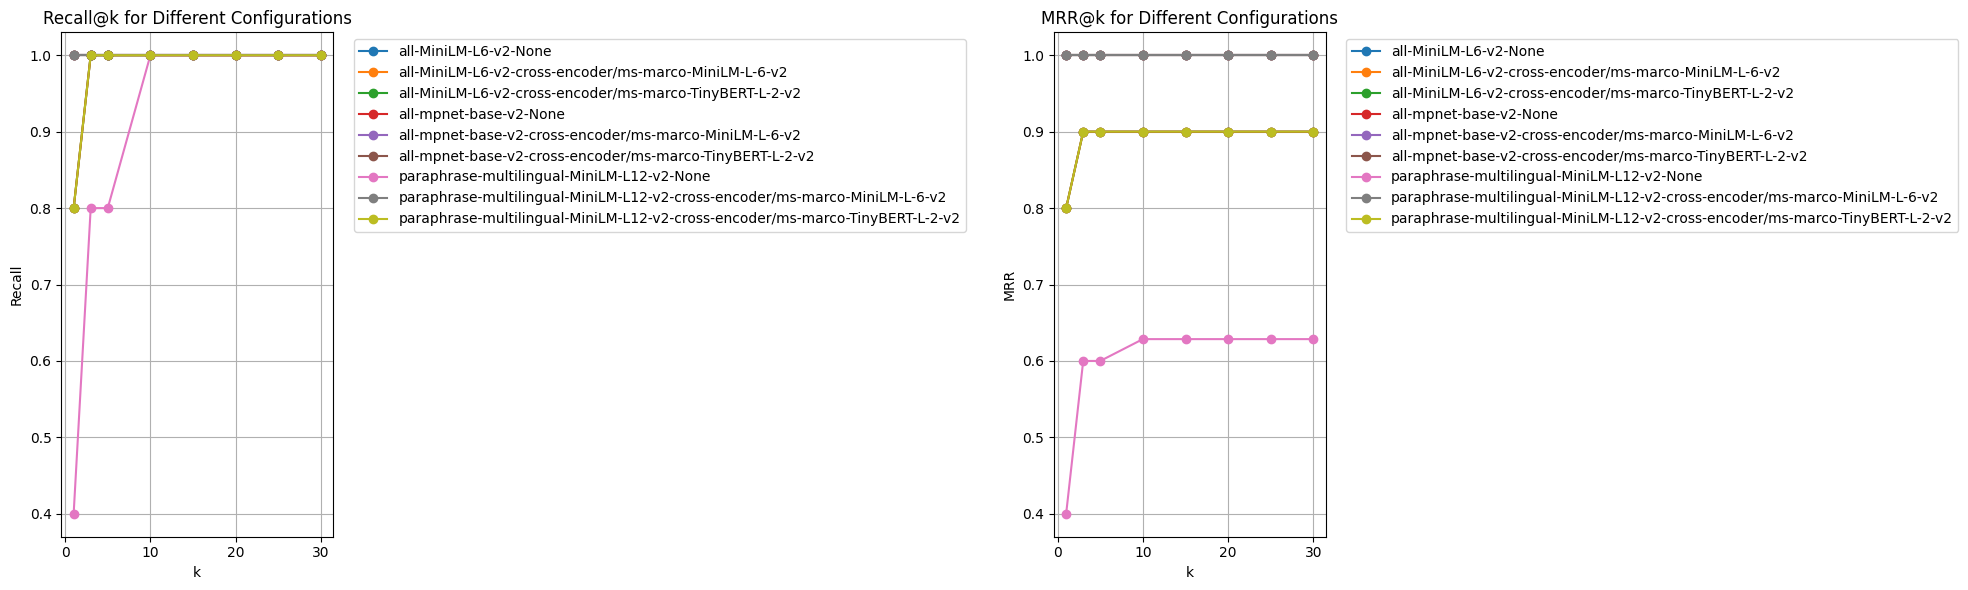

In [23]:
### Analyzing the Results

# Calculate average scores by configuration and k value
avg_results = evaluation_df.groupby(['embedding_model', 'reranker_model', 'k', 'metric'])['score'].mean().reset_index()

# Reshape for easier plotting
plot_data = avg_results.pivot_table(
    index=['embedding_model', 'reranker_model', 'k'],
    columns='metric',
    values='score'
).reset_index()

# Create plots comparing different configurations
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot recall for different configurations
recall_data = avg_results[avg_results['metric'] == 'recall']
for embedding in recall_data['embedding_model'].unique():
    for reranker in recall_data['reranker_model'].unique():
        data = recall_data[(recall_data['reranker_model'] == reranker) & 
                           (recall_data['embedding_model'] == embedding)]
        ax1.plot(data['k'], data['score'], marker='o', label=f"{embedding}-{reranker}")

ax1.set_title("Recall@k for Different Configurations")
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot MRR for different configurations
mrr_data = avg_results[avg_results['metric'] == 'mrr']
for embedding in mrr_data['embedding_model'].unique():
    for reranker in mrr_data['reranker_model'].unique():
        data = mrr_data[(mrr_data['reranker_model'] == reranker) & 
                         (mrr_data['embedding_model'] == embedding)]
        ax2.plot(data['k'], data['score'], marker='o', label=f"{embedding}-{reranker}")

ax2.set_title("MRR@k for Different Configurations")
ax2.set_xlabel("k")
ax2.set_ylabel("MRR")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('configuration_comparison.png')
plt.show()

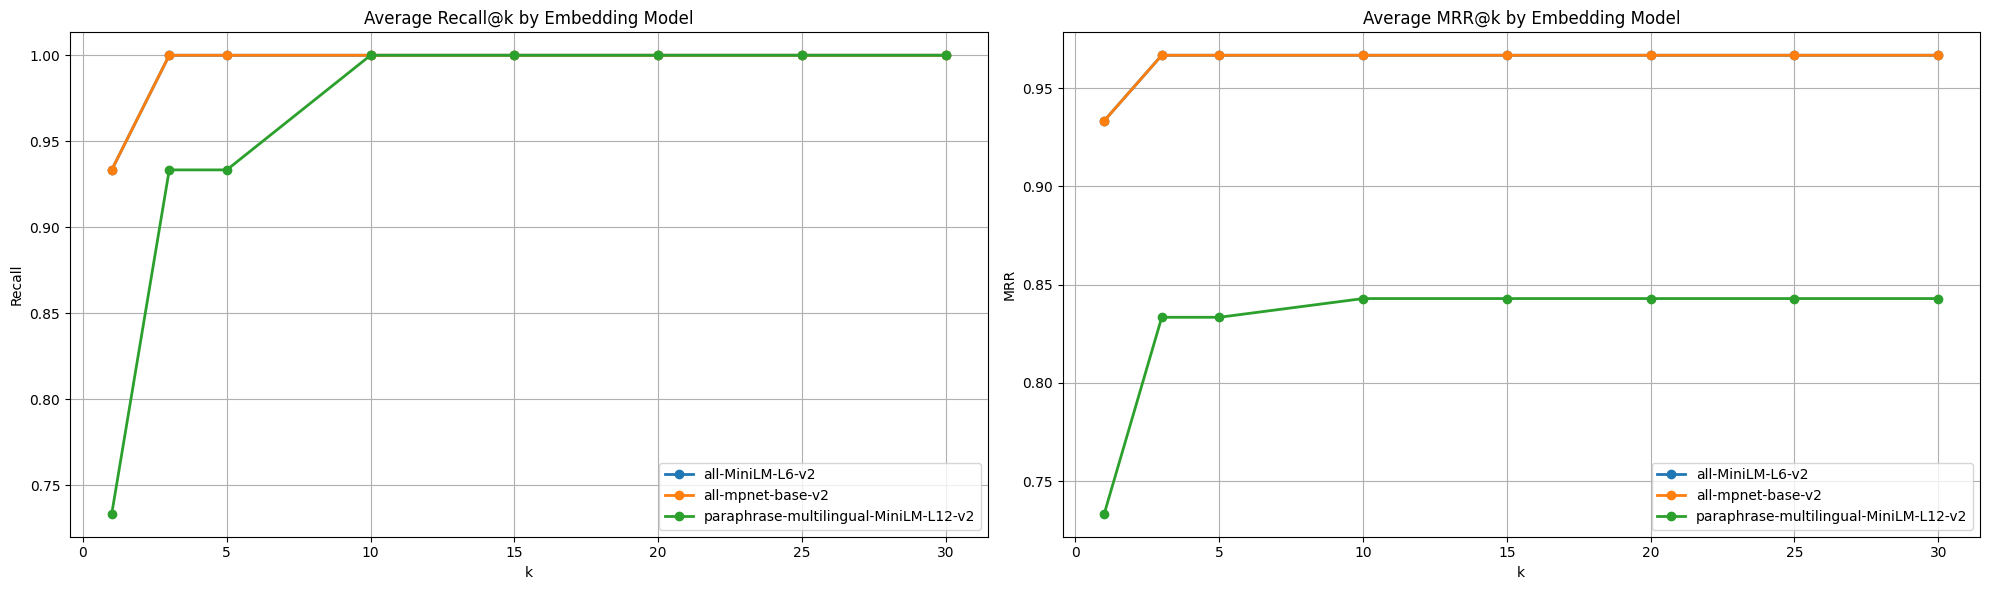

In [24]:
### Comparing Embedding Models (Averaging Across Rerankers)

# Average across rerankers to compare embedding models
embedding_comparison = avg_results.groupby(['embedding_model', 'k', 'metric'])['score'].mean().reset_index()

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot recall by embedding model
for embedding in embedding_comparison['embedding_model'].unique():
    data = embedding_comparison[(embedding_comparison['metric'] == 'recall') & 
                               (embedding_comparison['embedding_model'] == embedding)]
    ax1.plot(data['k'], data['score'], marker='o', linewidth=2, label=embedding)

ax1.set_title("Average Recall@k by Embedding Model")
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.grid(True)
ax1.legend()

# Plot MRR by embedding model
for embedding in embedding_comparison['embedding_model'].unique():
    data = embedding_comparison[(embedding_comparison['metric'] == 'mrr') & 
                               (embedding_comparison['embedding_model'] == embedding)]
    ax2.plot(data['k'], data['score'], marker='o', linewidth=2, label=embedding)

ax2.set_title("Average MRR@k by Embedding Model")
ax2.set_xlabel("k")
ax2.set_ylabel("MRR")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig('embedding_comparison.png')
plt.show()

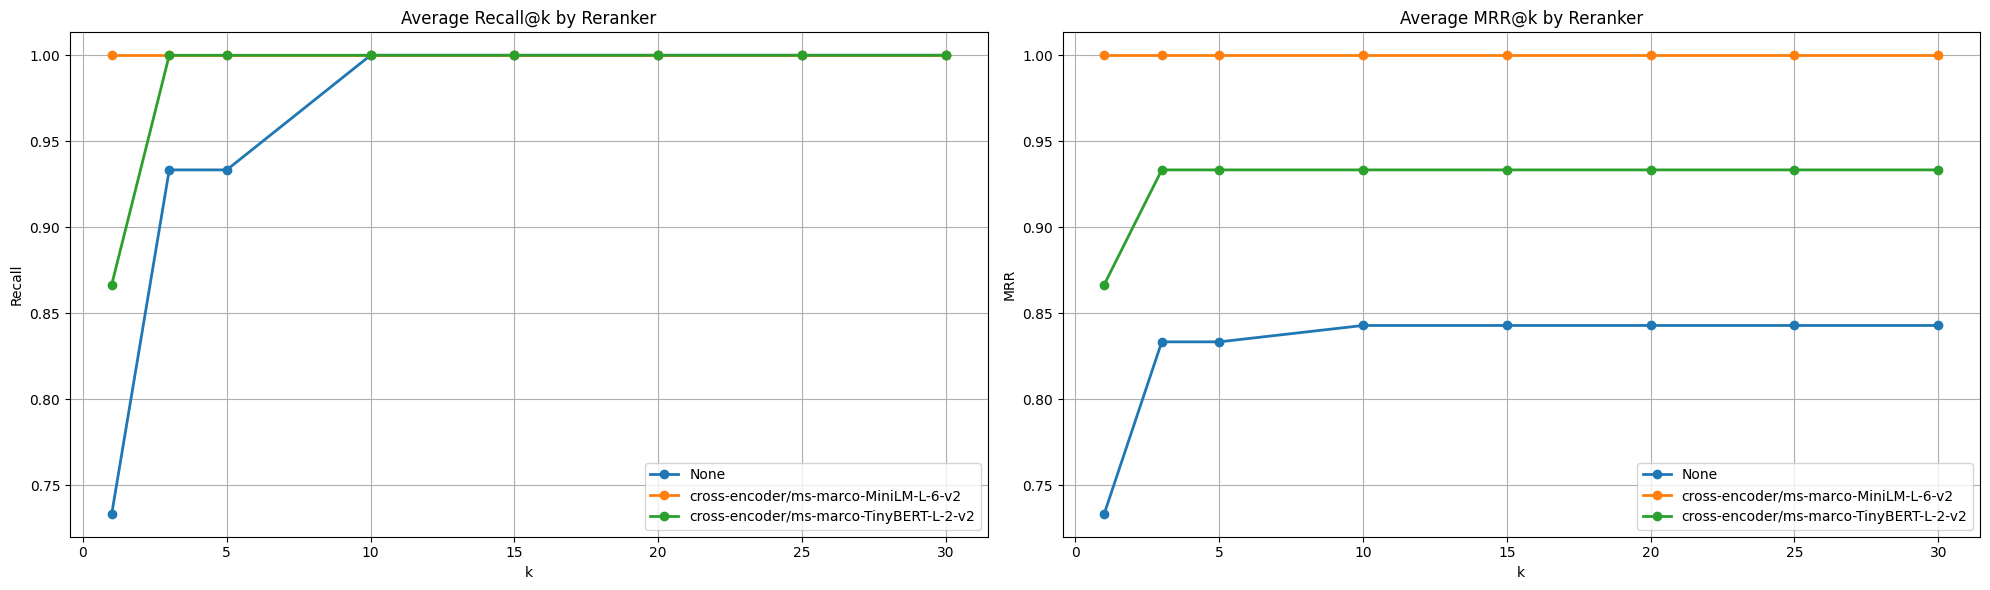

In [25]:
### Comparing Rerankers (Averaging Across Embedding Models)

# Average across embedding models to compare rerankers
reranker_comparison = avg_results.groupby(['reranker_model', 'k', 'metric'])['score'].mean().reset_index()

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot recall by reranker
for reranker in reranker_comparison['reranker_model'].unique():
    data = reranker_comparison[(reranker_comparison['metric'] == 'recall') & 
                              (reranker_comparison['reranker_model'] == reranker)]
    ax1.plot(data['k'], data['score'], marker='o', linewidth=2, label=reranker)

ax1.set_title("Average Recall@k by Reranker")
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.grid(True)
ax1.legend()

# Plot MRR by reranker
for reranker in reranker_comparison['reranker_model'].unique():
    data = reranker_comparison[(reranker_comparison['metric'] == 'mrr') & 
                              (reranker_comparison['reranker_model'] == reranker)]
    ax2.plot(data['k'], data['score'], marker='o', linewidth=2, label=reranker)

ax2.set_title("Average MRR@k by Reranker")
ax2.set_xlabel("k")
ax2.set_ylabel("MRR")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig('reranker_comparison.png')
plt.show()

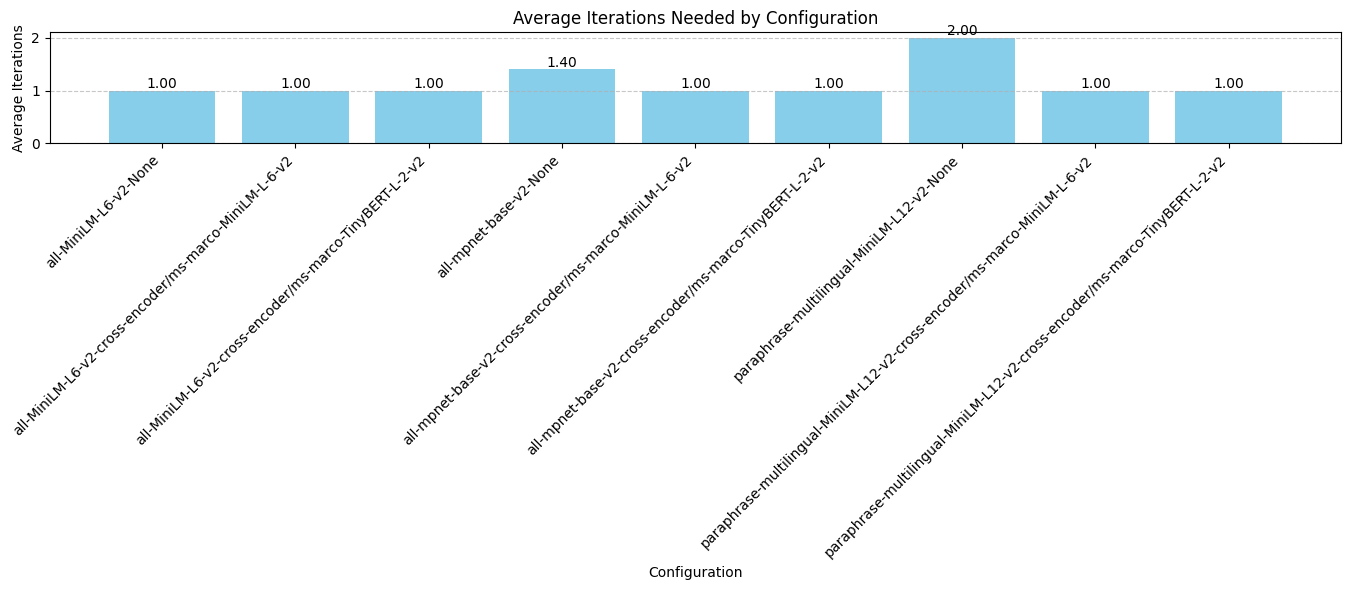

In [26]:
### Analyzing Number of Iterations by Configuration

# Calculate average iterations needed for each configuration
iterations_by_config = evaluation_df.groupby(['embedding_model', 'reranker_model'])['iterations'].mean().reset_index()

# Create a bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(
    range(len(iterations_by_config)), 
    iterations_by_config['iterations'],
    color='skyblue'
)

# Add labels
plt.xticks(
    range(len(iterations_by_config)), 
    [f"{row['embedding_model']}-{row['reranker_model']}" for _, row in iterations_by_config.iterrows()],
    rotation=45,
    ha='right'
)
plt.title("Average Iterations Needed by Configuration")
plt.xlabel("Configuration")
plt.ylabel("Average Iterations")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.05,
        f"{bar.get_height():.2f}",
        ha='center'
    )

plt.tight_layout()
plt.savefig('iterations_by_config.png')
plt.show()

In [27]:
### Finding the Best Configuration

# Calculate average Recall@10 and MRR@10 for each configuration
best_configs = evaluation_df[evaluation_df['k'] == 10].pivot_table(
    index=['embedding_model', 'reranker_model'],
    columns='metric',
    values='score',
    aggfunc='mean'
).reset_index()

# Sort by Recall and MRR
best_by_recall = best_configs.sort_values('recall', ascending=False).head(3)
best_by_mrr = best_configs.sort_values('mrr', ascending=False).head(3)

print("Top 3 Configurations by Recall@10:")
print(best_by_recall[['embedding_model', 'reranker_model', 'recall']])

print("\nTop 3 Configurations by MRR@10:")
print(best_by_mrr[['embedding_model', 'reranker_model', 'mrr']])

# Create a combined score (average of normalized Recall and MRR)
best_configs['recall_norm'] = best_configs['recall'] / best_configs['recall'].max()
best_configs['mrr_norm'] = best_configs['mrr'] / best_configs['mrr'].max()
best_configs['combined_score'] = (best_configs['recall_norm'] + best_configs['mrr_norm']) / 2

best_overall = best_configs.sort_values('combined_score', ascending=False).head(3)

print("\nTop 3 Configurations by Combined Score:")
print(best_overall[['embedding_model', 'reranker_model', 'recall', 'mrr', 'combined_score']])

Top 3 Configurations by Recall@10:
metric   embedding_model                          reranker_model  recall
0       all-MiniLM-L6-v2                                    None     1.0
1       all-MiniLM-L6-v2    cross-encoder/ms-marco-MiniLM-L-6-v2     1.0
2       all-MiniLM-L6-v2  cross-encoder/ms-marco-TinyBERT-L-2-v2     1.0

Top 3 Configurations by MRR@10:
metric    embedding_model                        reranker_model  mrr
0        all-MiniLM-L6-v2                                  None  1.0
1        all-MiniLM-L6-v2  cross-encoder/ms-marco-MiniLM-L-6-v2  1.0
4       all-mpnet-base-v2  cross-encoder/ms-marco-MiniLM-L-6-v2  1.0

Top 3 Configurations by Combined Score:
metric    embedding_model                        reranker_model  recall  mrr  combined_score
0        all-MiniLM-L6-v2                                  None     1.0  1.0             1.0
1        all-MiniLM-L6-v2  cross-encoder/ms-marco-MiniLM-L-6-v2     1.0  1.0             1.0
4       all-mpnet-base-v2  cross-encoder/ms-